# SegNet Implementation

In [23]:
import tensorflow
import h5py
#from PIL import Image
import numpy as np
#import matplotlib.pyplot as plt

In [24]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,Convolution2D
from keras.layers import BatchNormalization, Reshape, Layer
from keras.layers import Activation, Flatten, Dense
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import losses

In [25]:
hf = h5py.File('/home/joseph/Documents/data/Segmentation/HDF5/database_64.hdf5', 'r')

In [26]:
list(hf.keys())

['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']

In [27]:
train = hf['train_img'][:]
train = np.stack([train,train,train],axis=-1)

In [28]:
train.shape

(32, 64, 64, 1, 3)

In [29]:
#label = np.argmax(hf['train_label'],axis=3)
label = hf['train_label'][:]

In [30]:
train = train.reshape(32,64,64,3)

In [31]:
train.shape

(32, 64, 64, 3)

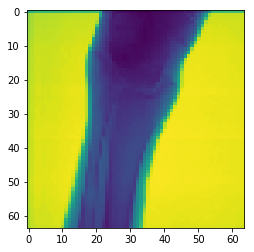

In [32]:
plt.imshow(train[0,...,0])

In [33]:
label = label.reshape((32,64*64,3))

In [34]:
label.shape

(32, 4096, 3)

In [17]:
input_shape=(200, 200, 3)
classes=3

# c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
img_input = Input(shape=input_shape)
x = img_input
# Encoder
x = Conv2D(64, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
print(x.shape)

x = Conv2D(128, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
print(x.shape)

x = Conv2D(256, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
print(x.shape)

x = Conv2D(512, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

# Decoder
x = Conv2D(512, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding="same")(x)
print(x.shape)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Convolution2D(classes, (1,1), padding="valid")(x)
print(x.shape)


#x = Dense(classes,activation='softmax')(x)
#x = Flatten()(x)
print (x)
x = Reshape((input_shape[0]*input_shape[1],classes))(x)
print(x.shape)
x = Activation("softmax")(x)

model = Model(img_input, x)


(?, 200, 200, 64)
(?, 100, 100, 64)
(?, 100, 100, 128)
(?, 50, 50, 128)
(?, 50, 50, 256)
(?, 25, 25, 256)
(?, 25, 25, 512)
(?, 25, 25, 512)
(?, 50, 50, 512)
(?, 50, 50, 256)
(?, 100, 100, 256)
(?, 100, 100, 128)
(?, 200, 200, 128)
(?, 200, 200, 128)
(?, 200, 200, 3)
Tensor("conv2d_9/BiasAdd:0", shape=(?, 200, 200, 3), dtype=float32)
(?, 40000, 3)


In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics=["accuracy"])

In [ ]:
model.fit(train,label,epochs = 10)

Epoch 1/10


In [35]:
train.shape

(32, 64, 64, 3)

In [36]:
label.shape

(32, 4096, 3)

In [38]:
input_shape=(64, 64, 3)
classes=3

# c.f. https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
img_input = Input(shape=input_shape)
x = img_input
# Encoder
x = Conv2D(12, (3, 3), padding="same")(x)
print(x.shape)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
print(x.shape)

x = Conv2D(12, (3, 3), padding="same")(x)
print(x.shape)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Decoder
x = Conv2D(12, (3, 3), padding="same")(x)
print(x.shape)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = UpSampling2D(size=(2, 2))(x)
print(x.shape)
x = Conv2D(12, (3, 3), padding="same")(x)
print(x.shape)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Convolution2D(classes, (1,1), padding="valid")(x)
print(x.shape)


#x = Dense(classes,activation='softmax')(x)
#x = Flatten()(x)
print (x)
x = Reshape((input_shape[0]*input_shape[1],classes))(x)
print(x.shape)
x = Activation("softmax")(x)

model = Model(img_input, x)

(?, 64, 64, 12)
(?, 32, 32, 12)
(?, 32, 32, 12)
(?, 32, 32, 12)
(?, 64, 64, 12)
(?, 64, 64, 12)
(?, 64, 64, 3)
Tensor("conv2d_23/BiasAdd:0", shape=(?, 64, 64, 3), dtype=float32)
(?, 4096, 3)


In [39]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics=["accuracy"])

In [40]:
model.fit(train,label,epochs = 20, batch_size = 1)

Epoch 1/20
32/32 [==============================] - 2s 52ms/step - loss: 200.6957 - acc: 0.6703
Epoch 2/20
32/32 [==============================] - 1s 29ms/step - loss: 166.1871 - acc: 0.7391
Epoch 3/20
32/32 [==============================] - 1s 29ms/step - loss: 152.1199 - acc: 0.7643
Epoch 4/20
32/32 [==============================] - 1s 27ms/step - loss: 141.6057 - acc: 0.7909
Epoch 5/20
32/32 [==============================] - 1s 30ms/step - loss: 133.9011 - acc: 0.7985
Epoch 6/20
32/32 [==============================] - 1s 30ms/step - loss: 127.7660 - acc: 0.8074
Epoch 7/20
32/32 [==============================] - 1s 31ms/step - loss: 121.3653 - acc: 0.8207
Epoch 8/20
32/32 [==============================] - 1s 27ms/step - loss: 116.2266 - acc: 0.8277
Epoch 9/20
32/32 [==============================] - 1s 28ms/step - loss: 111.8135 - acc: 0.8310
Epoch 10/20
32/32 [==============================] - 1s 27ms/step - loss: 107.9629 - acc: 0.8389
Epoch 11/20
32/32 [====================

In [47]:
test = hf['test_img'][:]
test = np.stack([test,test,test],axis=-1)

In [48]:
test = test.reshape(7,64,64,3)

In [56]:
test[0].shape
test0 = test[0]
64*64
test0.shape

(64, 64, 3)

In [57]:
test0 = test0.reshape((1,64,64,3))

In [67]:
prediction = model.predict(test0)
prediction = prediction.reshape((64,64,3))

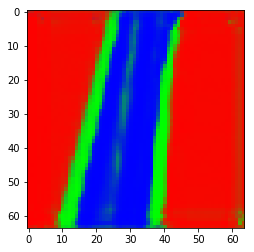

In [68]:
plt.imshow(prediction)

In [14]:
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

In [15]:
data_shape = 200*200



def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
    ]




segnet_basic = Sequential()

segnet_basic.add(Layer(input_shape=(200, 200, 3)))



segnet_basic.encoding_layers = create_encoding_layers()
for l in segnet_basic.encoding_layers:
    segnet_basic.add(l)

# Note: it this looks weird, that is because of adding Each Layer using that for loop
# instead of re-writting mode.add(somelayer+params) everytime.

segnet_basic.decoding_layers = create_decoding_layers()
for l in segnet_basic.decoding_layers:
    segnet_basic.add(l)

segnet_basic.add(Convolution2D(3, 1, 1, border_mode='valid',))

segnet_basic.add(Reshape((data_shape,3), input_shape=(200,200,3)))
#segnet_basic.add(Permute((2, 1)))
segnet_basic.add(Activation('softmax'))

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  if sys.path[0] == '':
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(

In [16]:
segnet_basic.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

In [17]:
label.shape

(383, 40000, 3)

In [ ]:
segnet_basic.fit(train,label,epochs = 1)

Epoch 1/1
